# Linear Regression 과제

#### 개요
<과제1> - 실습 코드에서 과제 부분을 채우고, 데이터에 추가해서 모델돌리기\
<과제2> - 추정된 회귀계수를 구하는 함수 구현하기 (행렬곱을 이용해서 간단하게, numpy사용, 5줄 이하) input: data_x(독립변수 행렬 데이터), data_y(종속변수 벡터 데이터) output: 추정된 회귀계수(벡터)\
<과제3> 1주차 Auction master 데이터로 회귀분석 (아래 목록들을 포함해야함) - 자유롭게 EDA, 전처리 (저번주 과제 참고o) - 변수 제거, 선택 시 이유 설명 - 다중공선성 확인, 처리 - fit된 모델의 평가(R-square, MSE 등등) (선택: 정규화, 변수선택법 등등)

#### 데이터 출처

1번 : 강의자님 제공 진단 데이터\
3번 : Auction master data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn import datasets
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


plt.style.use('seaborn')
warnings.filterwarnings('ignore')
%matplotlib inline
diabetes = datasets.load_diabetes()
random.seed(1)


In [2]:
df= pd.DataFrame(diabetes.data)
df.columns=['age','sex','bmi','bp','s1','s2','s3','s4','s5','s6']
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


강의자님이 데이터를 제공하실 때 이미 표준화 되어있었다.

In [3]:
labels = ['minor','junior','senior']
df["age_categories"] = pd.cut(df.age, 3, labels=labels)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,age_categories
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,senior
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,junior
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,senior
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,minor
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,junior


연속형으로 이루어진 age를 3가지 구간으로 나누어 인코딩합니다.

In [4]:
df['age_categories'].value_counts()

junior    212
minor     117
senior    113
Name: age_categories, dtype: int64

* 나이가 많을 수록 당뇨병 환자 수가 많을 것이라 생각했는데 senior층이 가장 적습니다. 
* 카테고리를 원-핫으로 바꿔주겠습니다.


In [5]:
age_dummy = pd.get_dummies(df.age_categories)
df = pd.concat([df.drop(['age','age_categories'], axis=1),age_dummy], axis=1)
df.head()

,sex,bmi,bp,s1,s2,s3,s4,s5,s6,minor,junior,senior
0,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,0,0,1
1,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,0,1,0
2,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,0,0,1
3,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,1,0,0
4,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,0,1,0


In [6]:
s_dummy = pd.get_dummies(df.sex, columns=['sex0','sex1'])
s_dummy.columns=['sex0','sex1']
df.drop(['sex'], axis=1, inplace=True)
df = pd.concat([df, s_dummy],axis=1)
df.head()

,bmi,bp,s1,s2,s3,s4,s5,s6,minor,junior,senior,sex0,sex1
0,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,0,0,1,0,1
1,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,0,1,0,1,0
2,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,0,0,1,0,1
3,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,1,0,0,1,0
4,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,0,1,0,1,0


성별에 따라서도 원핫 인코딩을 합니다.\
지금 보니 굳이 sex를 2개의 차원으로 할 것이 아닌, 하나의 feature로 0 또는 1 binary로 나타냈으면 더 나았을 것 같습니다.

In [7]:
df_y = pd.DataFrame(diabetes.target, columns=['target'])
df_y.head()


,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


# Model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(df, df_y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)
print('trainset R-square : ', model.score(X_train, y_train))
print('testset R-square : ', model.score(X_test, y_test))

trainset R-square :  0.5569673615589302
testset R-square :  0.30794909980252766


train set과 test set으로 나누고 선형회귀 모델을 학습시킵니다.

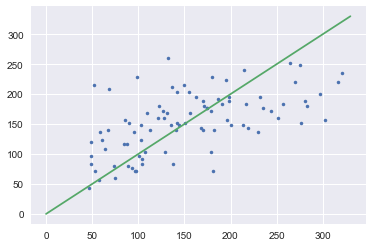

In [9]:
y_pred = model.predict(X_test) 
plt.plot(y_test, y_pred, '.')

x = np.linspace(0, 330, 100)
y = x
plt.plot(x, y)
plt.show()

# 과제 2

In [23]:
from numpy.linalg import inv

def calc_coeffs(x_data, y_data):
    coeffs = inv(x_data.transpose().dot(x_data)).dot(x_data.transpose()).dot(y_data)
    return coeffs
print(model.coef_) #추정된 회귀계수(intercept제외)
# print(model.intercept_) #intercept
coeffs = calc_coeffs(X_train, y_train)
feature_names = df.columns.values.tolist()

print('함수로 도출된 계수: \n', coeffs)

[ 0.00451042 -0.09722125  0.01981016  0.01521394 -0.05962986  1.01100012
 -0.00324003]
함수로 도출된 계수: 
 [ 0.00453807 -0.09722021  0.01980443  0.01524239 -0.05963317  1.01099141
 -0.00322815]


추정 회귀계수를 구하는 함수를 직접 구현합니다

# 과제 3 

In [11]:
data = pd.read_csv('../data/Auction_master_train.csv')
data.head(5)

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,...,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,...,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,...,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,...,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,...,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,...,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933 entries, 0 to 1932
Data columns (total 41 columns):
Auction_key                    1933 non-null int64
Auction_class                  1933 non-null object
Bid_class                      1933 non-null object
Claim_price                    1933 non-null int64
Appraisal_company              1933 non-null object
Appraisal_date                 1933 non-null object
Auction_count                  1933 non-null int64
Auction_miscarriage_count      1933 non-null int64
Total_land_gross_area          1933 non-null float64
Total_land_real_area           1933 non-null float64
Total_land_auction_area        1933 non-null float64
Total_building_area            1933 non-null float64
Total_building_auction_area    1933 non-null float64
Total_appraisal_price          1933 non-null int64
Minimum_sales_price            1933 non-null int64
First_auction_date             1933 non-null object
Final_auction_date             1933 non-null object
Final_resu

In [13]:
data.describe()

,Auction_key,Claim_price,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,addr_bunji1,addr_bunji2,Total_floor,Current_floor,road_bunji1,road_bunji2,point.y,point.x,Hammer_price
count,1933.000000,1.933000e+03,1933.000000,1933.000000,1.933000e+03,1933.000000,1933.000000,1933.000000,1933.000000,1.933000e+03,1.933000e+03,1929.000000,889.000000,1933.000000,1933.000000,1909.000000,155.000000,1933.000000,1933.000000,1.933000e+03
mean,1380.271081,3.703908e+08,1.836006,0.788412,3.458714e+04,42.333802,41.310776,96.417693,94.148810,4.973592e+08,4.155955e+08,601.952307,22.742407,16.980859,8.817900,127.441069,12.748387,36.698018,127.731667,4.726901e+08
std,801.670470,1.337869e+09,0.938319,0.831715,9.442101e+04,65.274404,65.385900,106.323240,106.845985,7.873851e+08,5.030312e+08,554.119824,67.000807,9.509021,8.044644,188.394217,10.735663,1.150269,0.993055,5.574493e+08
min,1.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000,0.000000,9.390000,1.500000,4.285000e+06,4.285000e+06,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,35.051385,126.809393,6.303000e+06
25%,691.000000,7.746112e+07,1.000000,0.000000,2.997000e+03,25.870000,24.570000,61.520000,59.970000,2.090000e+08,1.750000e+08,189.000000,1.000000,12.000000,3.000000,24.000000,5.000000,35.188590,126.959167,1.975550e+08
50%,1395.000000,1.728143e+08,2.000000,1.000000,1.424140e+04,37.510000,36.790000,84.900000,84.860000,3.600000e+08,3.120000e+08,482.000000,5.000000,15.000000,7.000000,57.000000,9.000000,37.500862,127.065003,3.544500e+08
75%,2062.000000,3.565089e+08,2.000000,1.000000,4.140310e+04,51.790000,51.320000,114.940000,114.850000,5.720000e+08,4.864000e+08,834.000000,18.000000,21.000000,12.000000,145.000000,17.500000,37.566116,129.018054,5.599000e+08
max,2762.000000,2.286481e+10,13.000000,9.000000,3.511936e+06,2665.840000,2665.840000,4255.070000,4255.070000,2.777500e+10,1.422080e+10,4937.000000,1414.000000,80.000000,65.000000,1716.000000,55.000000,37.685575,129.255872,1.515100e+10


* 결측치가 존재하는 변수들과 숫자로 이루어진 범주형 변수들이 보입니다.
* 회귀분석을 위해 연속형 변수들을 모아놓겠습니다.
* outlier가 몇몇 눈에 띄기 때문에 정제해주겠습니다.

In [14]:
num_data = data.select_dtypes(['int64','float'])
del_li = ['Auction_key', 'addr_bunji1', 'addr_bunji2', 'road_bunji1', 'road_bunji2','Current_floor','point.x','point.y']
num_data = num_data.drop(del_li, axis=1)
num_data.head()

,Claim_price,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,Total_floor,Hammer_price
0,1766037301,2,1,12592.0,37.35,37.35,181.77,181.77,836000000,668800000,45,760000000
1,152946867,2,1,42478.1,18.76,18.76,118.38,118.38,1073000000,858400000,70,971889999
2,11326510,3,2,149683.1,71.00,71.00,49.94,49.94,119000000,76160000,15,93399999
3,183581724,2,1,24405.0,32.98,32.98,84.91,84.91,288400000,230720000,20,256899000
4,45887671,2,1,774.0,45.18,45.18,84.96,84.96,170000000,136000000,7,158660000


In [15]:
from scipy import stats

# outlier 제거 
z = np.abs(stats.zscore(num_data))
num_data = num_data[(z < 3).all(axis=1)]

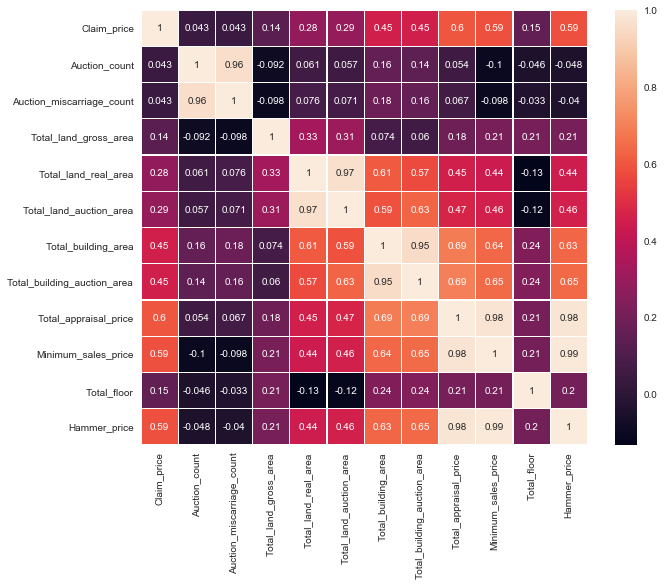

In [16]:
sns.heatmap(num_data.corr(),annot=True,linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [17]:
scaler = StandardScaler()
fitted = scaler.fit(num_data)
num_data2 = scaler.transform(num_data)
num_data2 = pd.DataFrame(num_data2, columns=num_data.columns, index=list(num_data.index.values))
num_data2.head()

,Claim_price,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,Total_floor,Hammer_price
0,5.235364,0.407011,0.491619,-0.426238,-0.141778,-0.092239,2.376015,2.358019,1.157820,1.006592,3.867893,0.989414
2,-0.834935,1.973700,2.170160,2.759754,1.382060,1.415126,-1.061699,-0.969517,-0.930990,-1.030929,-0.149958,-1.004315
3,-0.239030,0.407011,0.491619,-0.151704,-0.339673,-0.287995,-0.149791,-0.086835,-0.437483,-0.499545,0.519684,-0.515307
4,-0.715373,0.407011,0.491619,-0.700888,0.212803,0.258509,-0.148487,-0.085573,-0.782413,-0.825196,-1.221386,-0.809129
5,-0.509366,0.407011,0.491619,-0.518198,0.041173,0.088734,-0.161525,-0.098193,-0.630924,-0.682174,0.519684,-0.664582


* 계수가 매우 높은 변수가 많습니다. 다중공선성 높은 변수들이 있지않을까 의심되네요
* 특히 2개씩 짝지어서 거의 같은 얘기를 하고 있는 것 같은 변수들이 많습니다.
* 유독 층수와 토지 전체면적 등이 따로 노는 모습을 보이고 있습니다.

In [18]:
data_y = num_data2['Hammer_price']
data_x = num_data2.drop(['Hammer_price'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=0)

In [19]:
model = LinearRegression()
model.fit(x_train, y_train)
pred = model.predict(x_train)

# 변수 조작없이 도출된 결과
print('MSE : ', mean_squared_error(y_train, pred))
print('Train : ', model.score(x_train, y_train))
print('Test : ', model.score(x_test, y_test))


MSE :  0.019339297292312024
Train :  0.9812251289989846
Test :  0.9843123777362232


In [20]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    data_x.values, i) for i in range(data_x.shape[1])]
vif["features"] = data_x.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
5,127.010676,Total_land_auction_area
4,121.581259,Total_land_real_area
7,92.762413,Total_building_auction_area
6,85.388210,Total_building_area
8,57.287349,Total_appraisal_price
9,54.968362,Minimum_sales_price
2,14.515491,Auction_miscarriage_count
1,12.955659,Auction_count
0,1.571701,Claim_price
10,1.430085,Total_floor


* 변수를 조작하여 결과가 어떻게 달라지는지 보겠습니다.
* 경매 횟수 관련 변수, 면적관련 변수, 가격 관련 변수들 중에서 vif가 높은 것들을 추려내겠습니다. 

In [21]:
data_x2 = data_x.drop(['Auction_miscarriage_count','Total_building_area','Total_land_real_area','Minimum_sales_price'],axis=1)
data_x2.head()

,Claim_price,Auction_count,Total_land_gross_area,Total_land_auction_area,Total_building_auction_area,Total_appraisal_price,Total_floor
0,5.235364,0.407011,-0.426238,-0.092239,2.358019,1.157820,3.867893
2,-0.834935,1.973700,2.759754,1.415126,-0.969517,-0.930990,-0.149958
3,-0.239030,0.407011,-0.151704,-0.287995,-0.086835,-0.437483,0.519684
4,-0.715373,0.407011,-0.700888,0.258509,-0.085573,-0.782413,-1.221386
5,-0.509366,0.407011,-0.518198,0.088734,-0.098193,-0.630924,0.519684


In [22]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
warnings.filterwarnings(action='once')

X_train, X_test, Y_train, Y_test = train_test_split(data_x2, data_y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(X_train, Y_train)
pred = model.predict(X_train)

# 변수 조작업이 도출된 결과
print('MSE : ', mean_squared_error(Y_train, pred))
print('Train : ', model.score(X_train, Y_train))
print('Test : ', model.score(X_test, Y_test))

ridge=Ridge(alpha=0.3)
ridge.fit(X_train, Y_train)
print('Ridge : ', ridge.score(X_train,y_train))


MSE :  0.02904813370208266
Train :  0.9717996494477773
Test :  0.9732886459509594
Ridge :  0.9717995399403858
